## xDeepFM : the eXtreme Deep Factorization Machine

This notebook will give you a quick example of how to train an xDeepFM model. xDeepFM [1] is a deep learning-based model aims at capturing both lower- and higher-order feature interactions for precise recommender systems. Thus it can learn feature interactions more effectively and manual feature engineering effort can be substantially reduced. To summarize, xDeepFM has the following key properties:

- It contains a component, named CIN, that learns feature interactions in an explicit fashion and in vector-wise level;
- It contains a traditional DNN component that learns feature interactions in an implicit fashion and in bit-wise level.
- The implementation makes this model quite configurable. We can enable different subsets of components by setting hyperparameters like use_Linear_part, use_FM_part, use_CIN_part, and use_DNN_part. For example, by enabling only the use_Linear_part and use_FM_part, we can get a classical FM model.


In this notebook, we test xDeepFM on two datasets: 1) a small synthetic dataset and 2) Criteo dataset

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import xDeepFM
from deepctr.inputs import  SparseFeat, DenseFeat,get_feature_names
import os 

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

import warnings
warnings.filterwarnings('ignore')

Number of CPU cores: 8


In [7]:
# reading criteo_sample data
os.chdir(r'N:\ALGORITHMIC MARKETING\Assignment4')

data = pd.read_csv('data/criteo_sample.txt')
data.head(10)

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,NaN,3,260.0,NaN,17668.0,NaN,NaN,33.0,NaN,...,e5ba7672,87c6f83c,NaN,NaN,0429f84b,NaN,3a171ecb,c0d61a5c,NaN,NaN
1,0,NaN,-1,19.0,35.0,30251.0,247.0,1.0,35.0,160.0,...,d4bb7bd8,6fc84bfb,NaN,NaN,5155d8a3,NaN,be7c41b4,ded4aac9,NaN,NaN
2,0,0.0,0,2.0,12.0,2013.0,164.0,6.0,35.0,523.0,...,e5ba7672,675c9258,NaN,NaN,2e01979f,NaN,bcdee96c,6d5d1302,NaN,NaN
3,0,NaN,13,1.0,4.0,16836.0,200.0,5.0,4.0,29.0,...,e5ba7672,52e44668,NaN,NaN,e587c466,NaN,32c7478e,3b183c5c,NaN,NaN
4,0,0.0,0,104.0,27.0,1990.0,142.0,4.0,32.0,37.0,...,e5ba7672,25c88e42,21ddcdc9,b1252a9d,0e8585d2,NaN,32c7478e,0d4a6d1a,001f3601,92c878de
5,0,0.0,-1,63.0,40.0,1470.0,61.0,4.0,37.0,46.0,...,e5ba7672,d3303ea5,21ddcdc9,b1252a9d,7633c7c8,NaN,32c7478e,17f458f7,001f3601,71236095
6,0,0.0,370,4.0,1.0,1787.0,65.0,14.0,25.0,489.0,...,3486227d,642f2610,55dd3565,b1252a9d,5c8dc711,NaN,423fab69,45ab94c8,2bf691b1,c84c4aec
7,1,19.0,10,30.0,10.0,1.0,3.0,33.0,47.0,126.0,...,e5ba7672,a78bd508,21ddcdc9,5840adea,c2a93b37,NaN,32c7478e,1793a828,e8b83407,2fede552
8,0,0.0,0,36.0,22.0,4684.0,217.0,9.0,35.0,135.0,...,e5ba7672,7ce63c71,NaN,NaN,af5dc647,NaN,dbb486d7,1793a828,NaN,NaN
9,0,2.0,11,8.0,23.0,30.0,11.0,2.0,8.0,23.0,...,07c540c4,c21c3e4c,21ddcdc9,a458ea53,31c8e642,NaN,c7dc6720,3e983c86,9b3e8820,d597922b


In [8]:
# categorising the features into sparse/dense feature set
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

# data imputation for missing values
data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0,)

# creating target variable
target = ['label']

In [9]:
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,0.0,3,260.0,0.0,17668.0,0.0,0.0,33.0,0.0,...,e5ba7672,87c6f83c,-1,-1,0429f84b,-1,3a171ecb,c0d61a5c,-1,-1
1,0,0.0,-1,19.0,35.0,30251.0,247.0,1.0,35.0,160.0,...,d4bb7bd8,6fc84bfb,-1,-1,5155d8a3,-1,be7c41b4,ded4aac9,-1,-1
2,0,0.0,0,2.0,12.0,2013.0,164.0,6.0,35.0,523.0,...,e5ba7672,675c9258,-1,-1,2e01979f,-1,bcdee96c,6d5d1302,-1,-1
3,0,0.0,13,1.0,4.0,16836.0,200.0,5.0,4.0,29.0,...,e5ba7672,52e44668,-1,-1,e587c466,-1,32c7478e,3b183c5c,-1,-1
4,0,0.0,0,104.0,27.0,1990.0,142.0,4.0,32.0,37.0,...,e5ba7672,25c88e42,21ddcdc9,b1252a9d,0e8585d2,-1,32c7478e,0d4a6d1a,001f3601,92c878de


In [10]:
# encoding function
def encoding(data,feat,encoder):
    data[feat] = encoder.fit_transform(data[feat])
# encoding for categorical features
[encoding(data,feat,LabelEncoder()) for feat in sparse_features]
# Using normalization for dense feature
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])


In [11]:
# creating a 4 bit embedding for every sparse feature
sparse_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4) \
for i,feat in enumerate(sparse_features)]

In [12]:
# creating a dense feat
dense_feature_columns = [DenseFeat(feat, 1) for feat in dense_features]

In [13]:
# features to be used for dnn part of xdeepfm
dnn_feature_columns = sparse_feature_columns + dense_feature_columns
# features to be used for linear part of xdeepfm
linear_feature_columns = sparse_feature_columns + dense_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [15]:
dnn_feature_columns

[SparseFeat(name='C1', vocabulary_size=27, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C1', group_name='default_group'),
 SparseFeat(name='C2', vocabulary_size=92, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C2', group_name='default_group'),
 SparseFeat(name='C3', vocabulary_size=172, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C3', group_name='default_group'),
 SparseFeat(name='C4', vocabulary_size=157, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C4', group_name='default_group'),
 SparseFeat(name='C5', vocabulary_size=12, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C5', group_name='default_group'),
 SparseFeat(name='C6', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C6', group_name='default_group'),
 SparseFeat(name='C7', vocabulary_size=183, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C7', group_name='default_group'),
 SparseFeat

In [16]:
linear_feature_columns

[SparseFeat(name='C1', vocabulary_size=27, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C1', group_name='default_group'),
 SparseFeat(name='C2', vocabulary_size=92, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C2', group_name='default_group'),
 SparseFeat(name='C3', vocabulary_size=172, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C3', group_name='default_group'),
 SparseFeat(name='C4', vocabulary_size=157, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C4', group_name='default_group'),
 SparseFeat(name='C5', vocabulary_size=12, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C5', group_name='default_group'),
 SparseFeat(name='C6', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C6', group_name='default_group'),
 SparseFeat(name='C7', vocabulary_size=183, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C7', group_name='default_group'),
 SparseFeat

In [51]:
# creating train test splits
train, test = train_test_split(data, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [52]:
model = xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256),\
cin_layer_size=(128, 128), \
cin_split_half=True, cin_activation='relu'\
,l2_reg_linear=1e-05,\
l2_reg_embedding=1e-05, l2_reg_dnn=0, l2_reg_cin=0, \
init_std=0.0001,seed=1024, dnn_dropout=0,dnn_activation='relu', \
dnn_use_bn=False, task='binary')

In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
C3 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
C4 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
C5 (InputL

In [54]:
train_model_input

{'C1': array([17,  0,  0,  9,  9,  0, 14,  0, 25,  0,  0,  0, 11, 11,  0, 25,  0,
         0,  0,  0, 11,  0, 11, 11,  6,  0, 10,  0,  0, 11,  0, 16,  9, 11,
        16, 11,  0,  6, 15, 21, 11,  0, 23, 11,  0, 11, 21, 11,  9,  0,  0,
        11,  6, 16,  9, 16,  0,  0, 11,  0,  0,  0,  9,  0, 16,  0,  0, 11,
         8,  0, 21,  0,  0,  0,  0, 10,  0,  0,  0,  9, 11,  3,  0,  0, 21,
         0, 11, 11,  5,  0,  0, 14, 19,  9, 16,  1, 20, 19, 13, 18,  0, 18,
         6,  0,  0,  0, 16, 11,  0,  0,  0, 11,  0,  0,  0,  0, 11,  0,  7,
         0,  0, 11,  9,  2, 11,  0,  0,  0, 16,  3, 11,  0,  9,  6, 11, 26,
        16, 11,  9, 16,  0,  0, 21, 16, 11,  0,  0,  0,  6, 11,  0, 11,  0,
         0, 11,  0,  0,  0,  0,  9]),
 'C2': array([67, 49, 18, 58, 39, 19, 18, 18, 50, 13, 46, 25, 62,  3, 44, 18, 52,
         5, 31, 90, 17, 18, 24,  1, 74, 11, 26,  5, 30, 13, 55,  7, 28, 84,
        33, 44, 21, 39, 35, 66, 42, 77, 69, 18, 46, 10, 78,  5, 37, 45, 18,
        18, 30, 30, 15,  0, 27, 18, 85

In [56]:
#compiling the model
model.compile("adam", "binary_crossentropy",metrics=['binary_crossentropy','accuracy'], )
# training the model
history = model.fit(train_model_input, train[target].values,
                    batch_size=128, epochs=10, verbose=2, validation_split=0.2, )

Train on 128 samples, validate on 32 samples
Epoch 1/10
 - 13s - loss: 0.4584 - binary_crossentropy: 0.4584 - acc: 0.7734 - val_loss: 0.6117 - val_binary_crossentropy: 0.6117 - val_acc: 0.6875
Epoch 2/10
 - 0s - loss: 0.4475 - binary_crossentropy: 0.4475 - acc: 0.7734 - val_loss: 0.6124 - val_binary_crossentropy: 0.6124 - val_acc: 0.6875
Epoch 3/10
 - 0s - loss: 0.4349 - binary_crossentropy: 0.4348 - acc: 0.7734 - val_loss: 0.6096 - val_binary_crossentropy: 0.6096 - val_acc: 0.6875
Epoch 4/10
 - 0s - loss: 0.4192 - binary_crossentropy: 0.4191 - acc: 0.7734 - val_loss: 0.6050 - val_binary_crossentropy: 0.6050 - val_acc: 0.6875
Epoch 5/10
 - 0s - loss: 0.4023 - binary_crossentropy: 0.4023 - acc: 0.7734 - val_loss: 0.6000 - val_binary_crossentropy: 0.6000 - val_acc: 0.6875
Epoch 6/10
 - 0s - loss: 0.3851 - binary_crossentropy: 0.3850 - acc: 0.7734 - val_loss: 0.5948 - val_binary_crossentropy: 0.5947 - val_acc: 0.6875
Epoch 7/10
 - 0s - loss: 0.3659 - binary_crossentropy: 0.3658 - acc: 0.7

In [57]:
#predicting
pred_ans_xdeep = model.predict(test_model_input, batch_size=128)
pred_ans_xdeep[:10]

array([[0.19193242],
       [0.17235164],
       [0.19620614],
       [0.14274383],
       [0.28250262],
       [0.27839956],
       [0.21118242],
       [0.30484456],
       [0.24372973],
       [0.20166272]], dtype=float32)

In [58]:
score = model.evaluate(test_model_input, test[target].values, verbose=0)
print('Test Cross Entropy: ', score[1])
print('Test Accuracy', score[2])

Test Cross Entropy:  0.6148284792900085
Test Accuracy 0.75


dict_keys(['val_loss', 'val_binary_crossentropy', 'val_acc', 'loss', 'binary_crossentropy', 'acc'])


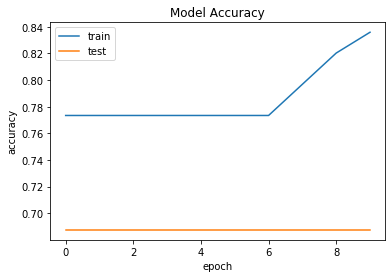

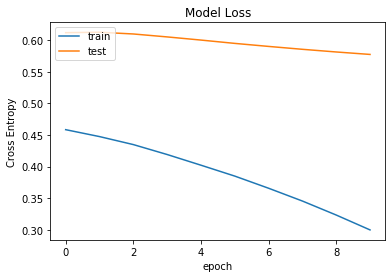

In [59]:
import matplotlib.pyplot as plt 

train_history = history
# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['binary_crossentropy'])
plt.plot(train_history.history['val_binary_crossentropy'])
plt.title('Model Loss')
plt.ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
model.save('xDeepFM_Model')